# play_SignedDistance_EDContact
# modified from Hydroelastic Contact: Nonconvex Mesh
For instructions on how to run these tutorial notebooks, please see the [index](./index.ipynb).

If you are not familiar with Drake's hydroelastic contact, study [hydroelastic_contact_basics.ipynb](./hydroelastic_contact_basics.ipynb). You can also find more information in Hydroelastic Contact User Guide [here.](https://drake.mit.edu/doxygen_cxx/group__hydroelastic__user__guide.html)

## Introduction

This tutorial shows you how to set up simulations using compliant-hydroelastic nonconvex meshes. We'll use a simple example of a bell pepper dropped onto a bowl on a table top, with all three objects represented by compliant-hydroelastic meshes. Contact forces are calculated and visualized.

In [ ]:
import numpy as np
import os
from pathlib import Path
from IPython.display import Code

from pydrake.geometry import (
    ConvertVolumeToSurfaceMesh, FeatureNormalSet, Rgba, Sphere, StartMeshcat,
    SurfaceTriangle, TriangleSurfaceMesh)
from pydrake.math import RigidTransform
from pydrake.multibody.meshcat import ContactVisualizer, ContactVisualizerParams
from pydrake.multibody.parsing import PackageMap, Parser
from pydrake.multibody.plant import AddMultibodyPlant, MultibodyPlantConfig
from pydrake.systems.analysis import Simulator
from pydrake.systems.framework import DiagramBuilder
from pydrake.visualization import ApplyVisualizationConfig, ModelVisualizer, VisualizationConfig

## Start MeshCat

See the section [Viewing models](./authoring_multibody_simulation.ipynb#Viewing-models) in the tutorial [Authoring a Multibody Simulation](./authoring_multibody_simulation.ipynb) for an introduction to MeshCat.

In [ ]:
# Start the visualizer. The cell will output an HTTP link after the execution.
# Click the link and a MeshCat tab should appear in your browser.
meshcat = StartMeshcat()

## Create compliant-hydroelastic bell pepper, bowl, and table top

In [ ]:
bell_pepper_url = "package://drake_models/veggies/yellow_bell_pepper_no_stem_low.sdf"
bell_pepper_str = Path(PackageMap().ResolveUrl(bell_pepper_url)).read_text(encoding="utf-8")
bowl_url = "package://drake_models/dishes/evo_bowl_compliant.urdf"
bowl_str = Path(PackageMap().ResolveUrl(bowl_url)).read_text(encoding="utf-8")
table_top_url = "package://drake_models/dishes/table_top.urdf"
table_top_str = Path(PackageMap().ResolveUrl(table_top_url)).read_text(encoding="utf-8")

### Deactivate test mode

In [ ]:
test_mode = False
if test_mode:
    bowl_str = bowl_str.replace("evo_bowl_fine44k.vtk", 
                                "evo_bowl_coarse3k.vtk")

## Create Diagram of the scene and set up visualization

The function `add_scene()` below will create a scene using the assets that we created. It will use `Parser` to add the URDF and SDFormat strings into the scene.

The function `add_viz()` below will create visualization. First we will call `ApplyVisualizationConfig()` to visualize our assets. At this step we will set `publish_contacts=False`, so we can customize contact visualization afterwards. 

To visualize contact result, we will add `ContactVisualizer` with `newtons_per_meter= 20` and `newtons_meters_per_meter= 0.1`. It will draw a red arrow of length 1 meter for each force of 20 newtons and a blue arrow of length 1 meter for each torque of 0.1 newton\*meters. The next section will run the simulation.

In [ ]:
def add_scene(time_step):
    builder = DiagramBuilder()
    plant, scene_graph = AddMultibodyPlant(
        MultibodyPlantConfig(
            time_step=time_step,
            discrete_contact_approximation="lagged"),
        builder)
    parser = Parser(plant)

    # Load the assets that we created.
    parser.AddModels(url=bell_pepper_url)
    parser.AddModels(file_contents=bowl_str, file_type="urdf")
    parser.AddModels(url=table_top_url)

    # Weld the table top to the world so that it's fixed during simulation.
    # The top surface passes the world's origin.
    plant.WeldFrames(plant.world_frame(), 
                     plant.GetFrameByName("top_surface"))

    # Finalize the plant after loading the scene.
    plant.Finalize()

    # Place the bowl on top of the table.
    X_WB = RigidTransform(p=[0, 0, 0.03])
    plant.SetDefaultFreeBodyPose(plant.GetBodyByName("bowl"), X_WB)
    
    # Drop the bell pepper from above the rim of the bowl. 
    X_WC = RigidTransform(p=[-0.06, 0, 0.30])
    plant.SetDefaultFreeBodyPose(plant.GetBodyByName("yellow_bell_pepper_no_stem"), X_WC)

    return builder, plant

def add_viz(builder, plant):
    ApplyVisualizationConfig(
        builder=builder, meshcat=meshcat,
        config=VisualizationConfig(
                 default_proximity_color=Rgba(r=0.8, g=0.8, b=0.8, a=0.5),
                 publish_contacts=False))    
    ContactVisualizer.AddToBuilder(
        builder=builder, plant=plant, meshcat=meshcat,
        params=ContactVisualizerParams(
                 newtons_per_meter=20,
                 newton_meters_per_meter= 0.1))

## Run simulation

We will run the simulation. In MeshCat, the red arrow will represent the force `f`, and the blue arrow will represent the torque `tau`. You should see the contact patch moving around together with the force and torque vectors.

After running the code below, playback with `timeScale` = 0.1 to appreciate the contact dynamics. You should see the force and torque vectors oscillate synchronously with the rocking bell pepper and bowl. See the section *Playback recording of the simulation* in [hydroelastic_contact_basics.ipynb](./hydroelastic_contact_basics.ipynb) for more details.

Currently playing back the simulation will show contact force and torque correctly; however, it does not show contact patch appropriately, which could be confusing. Issue [19142](https://github.com/RobotLocomotion/drake/issues/19142) explains the problem in more details.

In [ ]:
# Clear MeshCat window from the previous blocks.
meshcat.Delete()
meshcat.DeleteAddedControls()

time_step = 1e-2
builder, plant = add_scene(time_step)
add_viz(builder, plant)

diagram = builder.Build()

simulator = Simulator(diagram)

sim_time = 2

meshcat.StartRecording()
simulator.set_target_realtime_rate(1)
simulator.AdvanceTo(sim_time)
meshcat.StopRecording()
meshcat.PublishRecording()

### Draw collision meshes of the three objects

In [ ]:
meshcat.SetProperty("illustration", "visible", False)
meshcat.SetProperty("contact_forces",  "visible", False)
meshcat.SetProperty("proximity", "visible", False)

scene_graph = diagram.GetSubsystemByName("scene_graph")
inspector = scene_graph.model_inspector()
query_object = scene_graph.get_query_output_port().Eval(
    scene_graph.GetMyContextFromRoot(simulator.get_context()))

all_ids = inspector.GetAllGeometryIds()
for id in all_ids:
  if inspector.GetName(id) == "yellow_bell_pepper_no_stem::collision" :
    pepper_id = id
  if inspector.GetName(id) == "bowl::collision" :
    bowl_id = id
  if inspector.GetName(id) == "table_top::collision" :
    table_id = id
    
    
pepper_mesh = ConvertVolumeToSurfaceMesh(
    inspector.maybe_get_hydroelastic_mesh(pepper_id))
print(f"pepper_mesh.num_vertices() = {pepper_mesh.num_vertices()}\n")

bowl_mesh = ConvertVolumeToSurfaceMesh(
    inspector.maybe_get_hydroelastic_mesh(bowl_id))
print(f"bowl_mesh.num_vertices() = {bowl_mesh.num_vertices()}\n")

table_mesh = ConvertVolumeToSurfaceMesh(
    inspector.maybe_get_hydroelastic_mesh(table_id))
print(f"table_mesh.num_vertices() = {table_mesh.num_vertices()}\n")

def DrawCollisionMeshInOneColorWithBlackEdges(name, id, mesh, surface_rgba):
  meshcat.SetTransform(f"{name}", query_object.GetPoseInWorld(id))
  meshcat.SetObject(f"{name}/shade", mesh, rgba = surface_rgba,
                    wireframe=False)
  meshcat.SetObject(f"{name}/wireframe", mesh, rgba=Rgba(0, 0, 0, 1),
                    wireframe=True, wireframe_line_width=2.0)

DrawCollisionMeshInOneColorWithBlackEdges("BellPepperMesh", pepper_id, pepper_mesh, Rgba(0.8, 0.8, 0, 0.5))
DrawCollisionMeshInOneColorWithBlackEdges("BowlMesh", bowl_id, bowl_mesh, Rgba(1, 1, 1, 1))
DrawCollisionMeshInOneColorWithBlackEdges("TableMesh", table_id, table_mesh, Rgba(0.9, 0.8, 0.7, 1))

### One call of ComputeSignedDistanceToPoint() with a query point

In [ ]:
meshcat.Delete("signed_distances")

# The query point is near the centroid of the bell pepper.
# The signed distances should be around -2 cm inside the bell pepper,
# +3.8 cm outside the bowl, and +4.4 cm above the table top.
p_WQ = [-0.016, -0.012, 0.044]
signed_distances = query_object.ComputeSignedDistanceToPoint(p_WQ)

def DrawSignedDistanceData(p_WQ, d):
  geometry_id = d.id_G
  geometry_name = inspector.GetName(geometry_id)
  grad_W = d.grad_W  
  p_GN = d.p_GN  
  X_WG = query_object.GetPoseInWorld(geometry_id)
  p_WN = X_WG.multiply(p_GN)
  color = Rgba(r=1, g=0, b=0, a=1)
  if d.distance < 0:
    color = Rgba(r=0, g=0, b=1, a=1)    
  # Draw a line between the query point and its nearest point.  
  meshcat.SetLine(path=f"signed_distances/{geometry_name}/nearest/to_p_WQ_{p_WQ}",
        vertices=np.array([p_WQ, p_WN]).T,
        line_width=2.0, rgba=color)
  # Draw a 1-cm line from the query point in the gradient direction.
  meshcat.SetLine(path=f"signed_distances/{geometry_name}/grad_W/to_p_WQ_{p_WQ}",
        vertices=np.array([p_WQ, p_WQ + 0.01 * grad_W]).T,
        line_width=4.0, rgba=Rgba(r=1, g=0, b=1, a=1)) 
  # Draw the query point p_WQ as a sphere with radius 0.1 cm
  query_point_path = f"signed_distances/{geometry_name}/p_WQ_{p_WQ}" 
  meshcat.SetObject(query_point_path, Sphere(0.001), rgba=Rgba(r=0, g=1, b=1, a=1))
  meshcat.SetTransform(query_point_path, RigidTransform(p=p_WQ))
  

for d in signed_distances:
  geometry_id = d.id_G  
  geometry_name = inspector.GetName(geometry_id)
  grad_W = d.grad_W  
  p_GN = d.p_GN  
  print(f"{geometry_name}")
  print(f"distance = {d.distance}")
  print(f"grad_W = {grad_W}")
  print(f"p_GN = {p_GN}")
  print(f"id_G = {geometry_id}")
  print()
  DrawSignedDistanceData(p_WQ, d)
    

### FeatureNormalSet on surfaces

In [ ]:
meshcat.Delete("signed_distances")

def DrawVertexNormal(name, geometry_id, mesh_M):
  vertex_list_M = [p_MV for p_MV in mesh_M.vertices()]
  vertices_M = np.array(vertex_list_M).transpose()
    
  feature_normals_M = FeatureNormalSet(mesh_M)
  vertex_normals_M_list = [feature_normals_M.vertex_normal(v)
                           for v in range(mesh_M.num_vertices())]
  vertex_normals_M = np.array(vertex_normals_M_list).transpose()
    
  starts_M = vertices_M
  ends_M = starts_M + 0.005 * vertex_normals_M
  meshcat.SetLineSegments(f"{name}/FeatureNormalSet/vertex_normals",
                          starts_M, ends_M, line_width=1,
                          rgba=Rgba(r=1, g=0, b=1, a=1))  
    
DrawCollisionMeshInOneColorWithBlackEdges("BellPepperMesh", pepper_id, pepper_mesh, Rgba(0.8, 0.8, 0, 1))
DrawCollisionMeshInOneColorWithBlackEdges("BowlMesh", bowl_id, bowl_mesh, Rgba(1, 1, 1, 1))
DrawCollisionMeshInOneColorWithBlackEdges("TableMesh", table_id, table_mesh, Rgba(0.9, 0.8, 0.7, 1))

DrawVertexNormal("BowlMesh", bowl_id, bowl_mesh)
DrawVertexNormal("BellPepperMesh", pepper_id, pepper_mesh)
DrawVertexNormal("TableMesh", table_id, table_mesh)

### Assign Bell Pepper's vertices the signed distances from Bowl, and vice versa.

In [ ]:
meshcat.Delete("signed_distances")
meshcat.SetProperty("BellPepperMesh", "visible", False)
meshcat.SetProperty("BowlMesh", "visible", False)
meshcat.SetProperty("TableMesh", "visible", False)
meshcat.SetProperty("BellPepperMesh/FeatureNormalSet", "visible", False)
meshcat.SetProperty("BowlMesh/FeatureNormalSet", "visible", False)
meshcat.SetProperty("TableMesh/FeatureNormalSet", "visible", False)


def DistanceColor(distance_value):
  # -0.1mm negative bound 
  kMinD = -0.0001
  # 1mm  positive bound
  kMaxD = 0.001
  # Background grayscale. Small positive number less than 1.  
  kGray = 0.2
  d = np.clip(distance_value, kMinD, kMaxD)    
  if d > 0:
    d_intensity = (1 - kGray) * d / kMaxD + kGray
  else:  
    d_intensity = (1 - kGray) * d / kMinD + kGray
  if d > 0:
    rgb_color = np.array([d_intensity, kGray, kGray])
  else:
    rgb_color = np.array([kGray, kGray, d_intensity])  
  return rgb_color

def SignedDistanceColor(signed_distances, id1):
  for d in signed_distances:
    if d.id_G == id1:
        return DistanceColor(d.distance)    
  return np.zeros([3,1])

# Compute vertices, triangles, and vertex_signed_distances in World frame
# of mesh0 with respect to mesh1.
# @param id0    GeometryId of mesh0
# @param mesh0  TriangleSurfaceMesh of mesh0
# @param id1    GeometryId of mesh1
# The return vertices has shape[3,n] where n is mesh0.num_vertices()
def VerticesTrianglesSignedDistance(id0, mesh0, id1):
  # P is the local frame of mesh0
  X_WP = query_object.GetPoseInWorld(id0)
    
  vertex_list = [X_WP.multiply(p_PQ)
                 for p_PQ in mesh0.vertices()]  
  vertices = np.array(vertex_list).transpose()
    
  triangle_list = [np.array([tri.vertex(0), tri.vertex(1), tri.vertex(2)])
                   for tri in mesh0.triangles()]
  triangles = np.array(triangle_list).transpose()
    
  signed_distances_list =  [query_object.ComputeSignedDistanceToPoint(p_WQ)
                           for p_WQ in vertex_list]
  color_list = [SignedDistanceColor(distances, id1)
                for distances in signed_distances_list]
  colors = np.array(color_list).transpose()  
  return vertices, triangles, colors


vertices, triangles, colors = VerticesTrianglesSignedDistance(pepper_id, pepper_mesh, bowl_id)
    
meshcat.Delete("BellPepper_with_BowlSDF")
meshcat.SetTriangleColorMesh("BellPepper_with_BowlSDF/shade",
                             vertices, triangles, colors, wireframe=False)
meshcat.SetTriangleColorMesh("BellPepper_with_BowlSDF/wireframe",
                             vertices, triangles, colors, wireframe=True)

vertices, triangles, colors = VerticesTrianglesSignedDistance(bowl_id, bowl_mesh, pepper_id)

meshcat.Delete("Bowl_with_PepperSDF")
meshcat.SetTriangleColorMesh("Bowl_with_PepperSDF/shade",
                             vertices, triangles, colors, wireframe=False)
meshcat.SetTriangleColorMesh("Bowl_with_PepperSDF/wireframe",
                             vertices, triangles, colors, wireframe=True)
    
meshcat.SetProperty("Bowl_with_PepperSDF", "visible", False)

### Use vtkClipPolyData and vtkImplicitPolyDataDistance to clip the pepper by the bowl, and vice versa

In [ ]:
import vtk

vtkPoints = vtk.vtkPoints()

def DrakeMeshTriangleToVtkTriangle(tri):
  triangle = vtk.vtkTriangle()
  triangle.GetPointIds().SetId(0, tri.vertex(0))
  triangle.GetPointIds().SetId(1, tri.vertex(1))
  triangle.GetPointIds().SetId(2, tri.vertex(2))
  return triangle

def GetVtkPolyData(id, drake_mesh):
  X_WP = query_object.GetPoseInWorld(id)    
  vertex_list = [X_WP.multiply(p_PQ)
                    for p_PQ in drake_mesh.vertices()]       
  points = vtk.vtkPoints()
  [points.InsertNextPoint(xyz[0], xyz[1], xyz[2])
      for xyz in vertex_list];
  triangles = vtk.vtkCellArray()
  [triangles.InsertNextCell(DrakeMeshTriangleToVtkTriangle(tri))
      for tri in drake_mesh.triangles()];
  polydata = vtk.vtkPolyData()
  polydata.SetPoints(points)
  polydata.SetPolys(triangles)
  return polydata

# For debugging
def Render(vtk_polydata):
  # Create a mapper and actor
  mapper = vtk.vtkPolyDataMapper()
  mapper.SetInputData(vtk_polydata)

  actor = vtk.vtkActor()
  actor.SetMapper(mapper)

  # Create a renderer, render window, and interactor
  renderer = vtk.vtkRenderer()
  renderWindow = vtk.vtkRenderWindow()
  renderWindow.AddRenderer(renderer)
  renderWindowInteractor = vtk.vtkRenderWindowInteractor()
  renderWindowInteractor.SetRenderWindow(renderWindow)

  # Add actor to the renderer
  renderer.AddActor(actor)
  renderer.SetBackground(0.1, 0.2, 0.4) 

  # Render and interact
  renderWindow.Render()
  renderWindowInteractor.Start()

# Clip polydata1 by polydata2
def ClipPolydata(polydata1, polydata2):
  clipper = vtk.vtkClipPolyData()
  clipper.InsideOutOn()
  # Subject mesh
  clipper.SetInputData(polydata1)
  # Clipper mesh
  distancefunction = vtk.vtkImplicitPolyDataDistance()
  distancefunction.SetInput(polydata2)
  clipper.SetClipFunction(distancefunction)
  clipper.Update()
  clipped_mesh = clipper.GetOutput()
  return clipped_mesh  

pepper_polydata = GetVtkPolyData(pepper_id, pepper_mesh)

bowl_polydata = GetVtkPolyData(bowl_id, bowl_mesh)

pepper_clipped_polydata = ClipPolydata(pepper_polydata, bowl_polydata)
bowl_clipped_polydata = ClipPolydata(bowl_polydata, pepper_polydata)

# For debugging
# Render(pepper_clipped_polydata)

### Convert vtkPolyData back to drake, and draw the patches on the meshes

In [ ]:
meshcat.SetProperty("BellPepper_with_BowlSDF", "visible", False)
meshcat.SetProperty("Bowl_with_PepperSDF", "visible", False)

meshcat.SetProperty("BellPepperMesh", "visible", True)
meshcat.SetProperty("BowlMesh", "visible", True)

DrawCollisionMeshInOneColorWithBlackEdges("BellPepperMesh", pepper_id, pepper_mesh,
                                          Rgba(0.8, 0.8, 0.8, 0.8))
DrawCollisionMeshInOneColorWithBlackEdges("BowlMesh", bowl_id, bowl_mesh,
                                          Rgba(0.8, 0.8, 0.8, 0.8))

def VtkTriangleToSurfaceTriangle(vtk_tri):
    v0 = vtk_tri.GetPointIds().GetId(0)
    v1 = vtk_tri.GetPointIds().GetId(1)
    v2 = vtk_tri.GetPointIds().GetId(2)
    return SurfaceTriangle(v0, v1, v2)

# Convert vtkPolyData to drake.geometry.TriangleSurfaceMesh
# Assume the vtkPolyData contains triangles only
def VtkPolyDataToDrakeTriangleSurfaceMesh(polydata):
  vertex_list = [np.array([polydata.GetPoint(i)]).transpose()
                    for i in range(polydata.GetNumberOfPoints())]
  triangle_list = [VtkTriangleToSurfaceTriangle(polydata.GetCell(i))
                      for i in range(polydata.GetNumberOfCells())]
  return TriangleSurfaceMesh(triangle_list, vertex_list)

pepper_clipped_mesh = VtkPolyDataToDrakeTriangleSurfaceMesh(pepper_clipped_polydata)
bowl_clipped_mesh = VtkPolyDataToDrakeTriangleSurfaceMesh(bowl_clipped_polydata)

def DrawClippedVerticesTrianglesSignedDistance(name, clipped_mesh0, id1):
  vertex_list = [p_PQ for p_PQ in clipped_mesh0.vertices()]  
  vertices = np.array(vertex_list).transpose()
    
  triangle_list = [np.array([tri.vertex(0), tri.vertex(1), tri.vertex(2)])
                   for tri in clipped_mesh0.triangles()]
  triangles = np.array(triangle_list).transpose()
    
  signed_distances_list =  [query_object.ComputeSignedDistanceToPoint(p_WQ)
                           for p_WQ in vertex_list]
  color_list = [SignedDistanceColor(distances, id1)
                for distances in signed_distances_list]
  colors = np.array(color_list).transpose()  
  meshcat.SetTriangleColorMesh(f"{name}/shade", vertices, triangles, colors, wireframe=False)
  meshcat.SetObject(f"{name}/wireframe", clipped_mesh0, rgba = Rgba(0, 0, 1, 1), wireframe=True,
                               wireframe_line_width=3.0)


DrawClippedVerticesTrianglesSignedDistance("BellPepperClippedByBowl",
                                            pepper_clipped_mesh, bowl_id)
DrawClippedVerticesTrianglesSignedDistance("BowlClippedByBellPepper",
                                            bowl_clipped_mesh, pepper_id)


### Draw pepper mesh with its clipped patch

In [ ]:
meshcat.SetProperty("BellPepperMesh", "visible", True)
meshcat.SetProperty("BellPepperClippedByBowl", "visible", True)
meshcat.SetProperty("BowlMesh", "visible", False)
meshcat.SetProperty("BowlClippedByBellPepper", "visible", False)

### Draw bowl mesh with its clipped patch

In [ ]:
meshcat.SetProperty("BellPepperMesh", "visible", False)
meshcat.SetProperty("BellPepperClippedByBowl", "visible", False)
meshcat.SetProperty("BowlMesh", "visible", True)
meshcat.SetProperty("BowlClippedByBellPepper", "visible", True)

### Captured Images

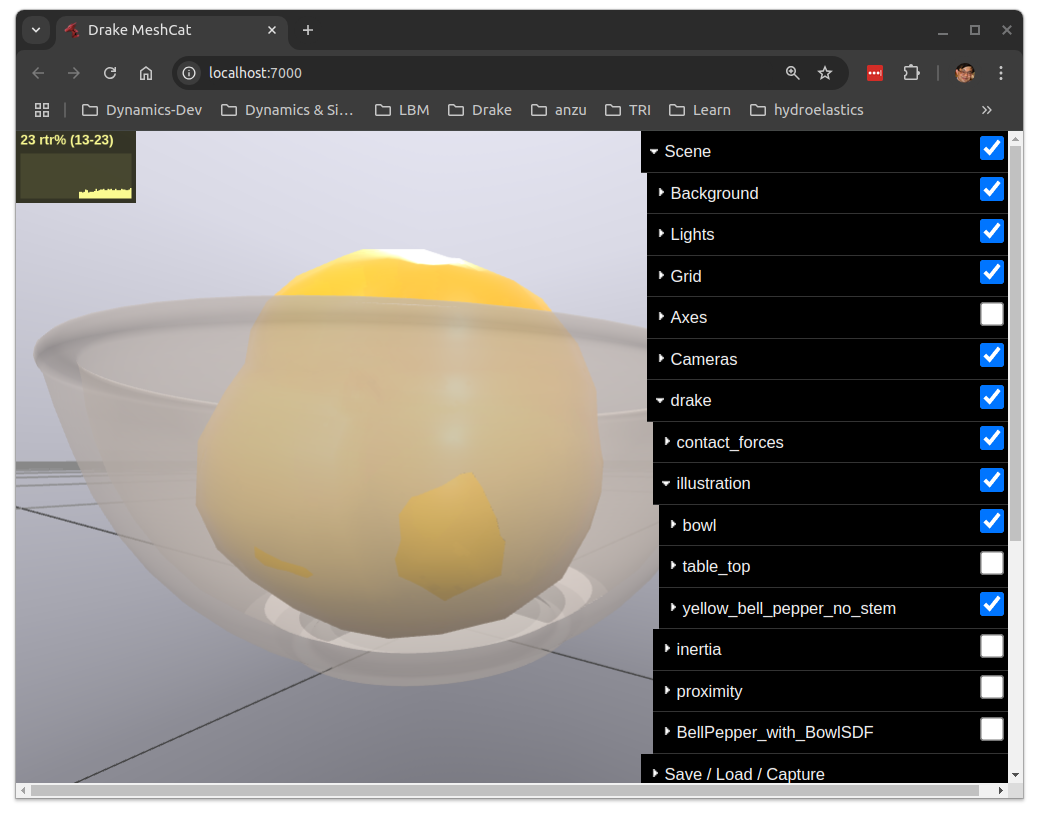

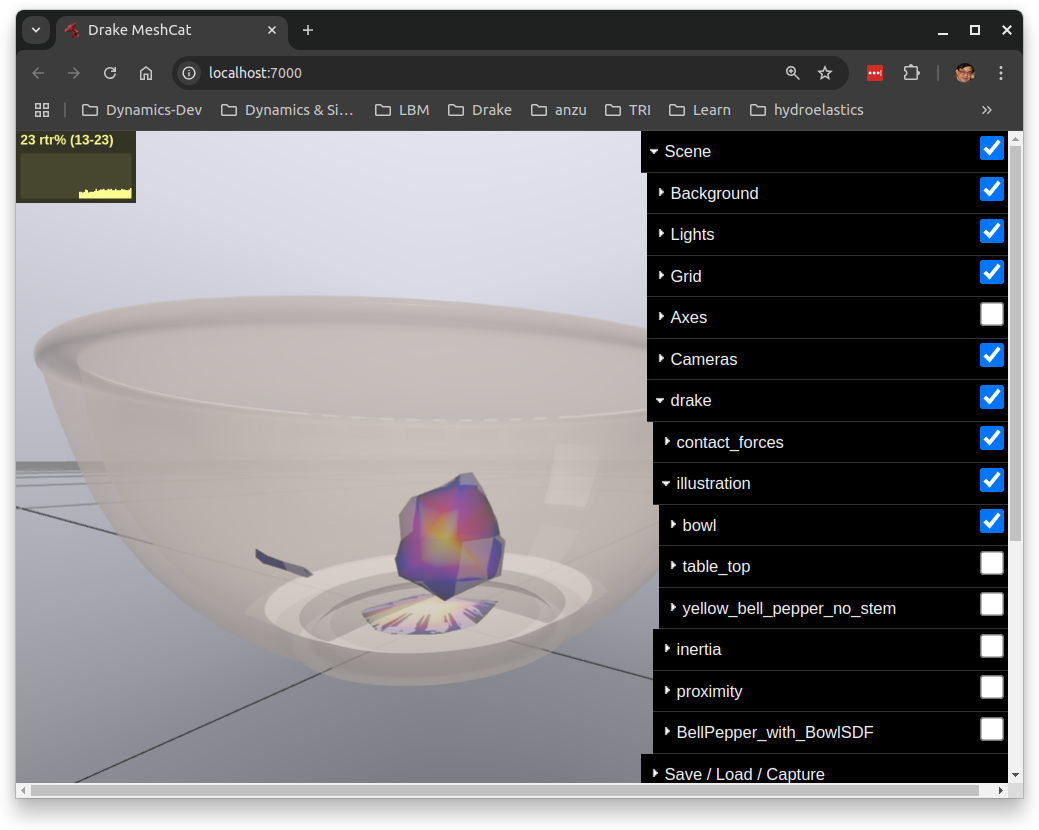

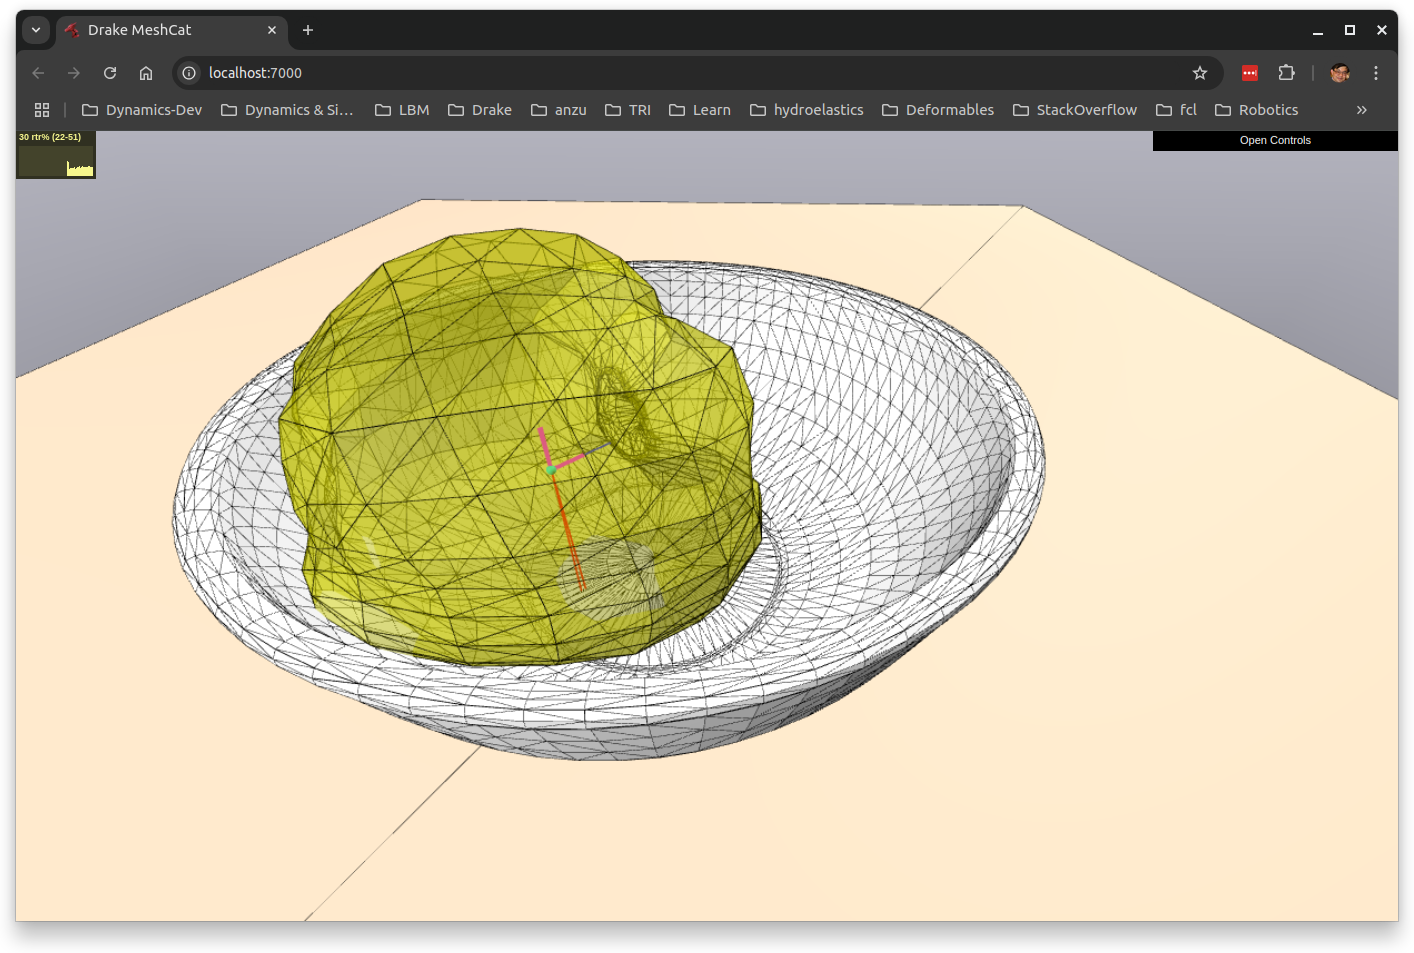

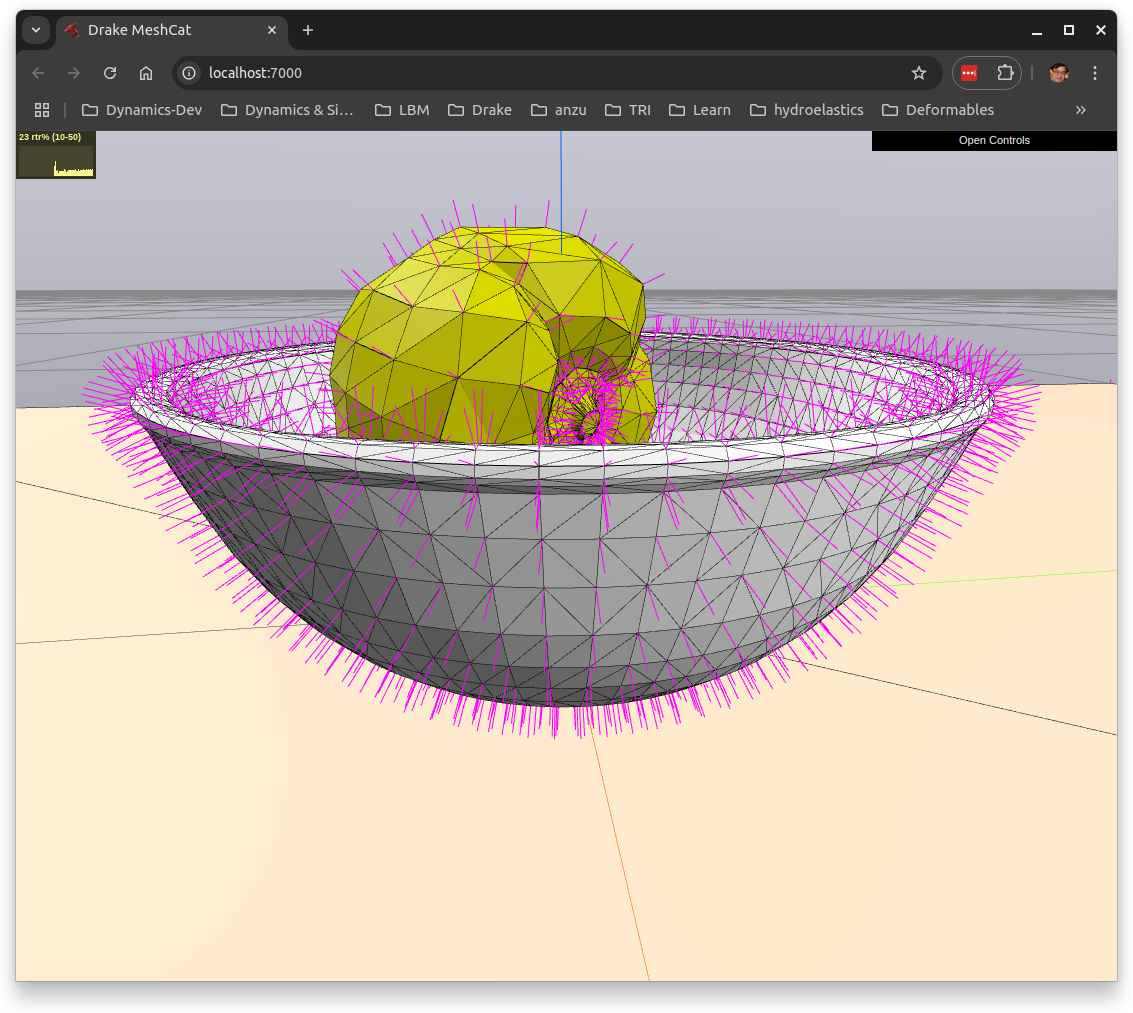

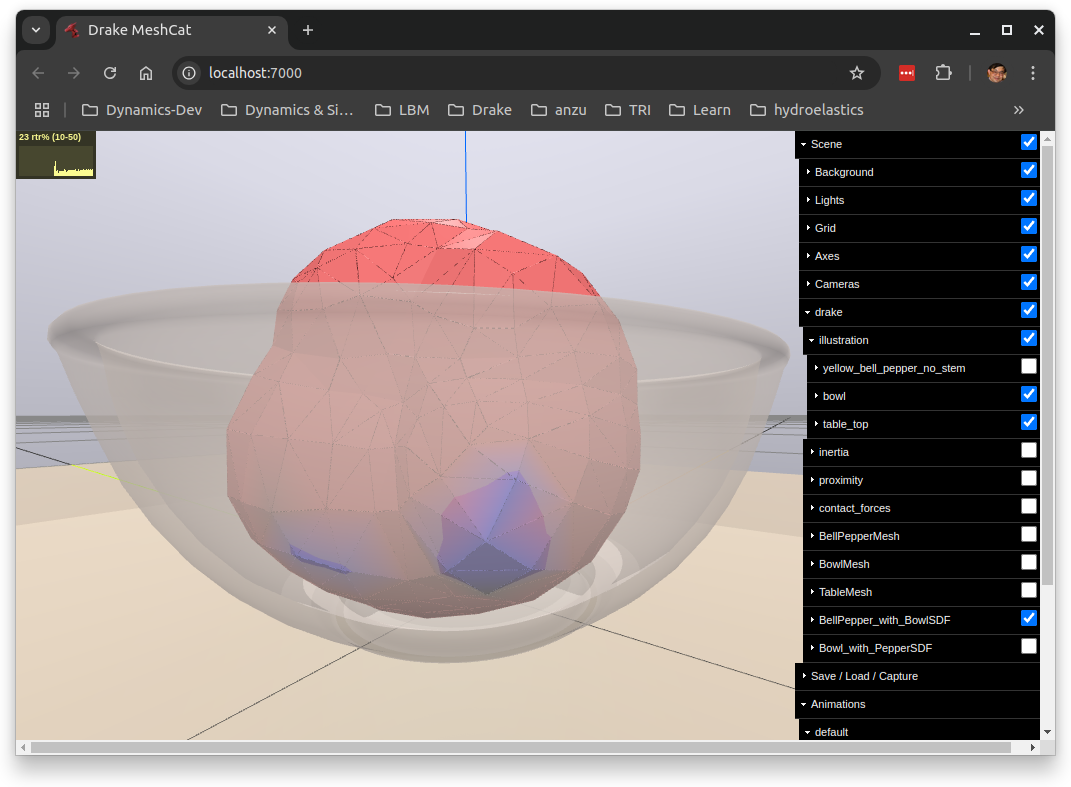

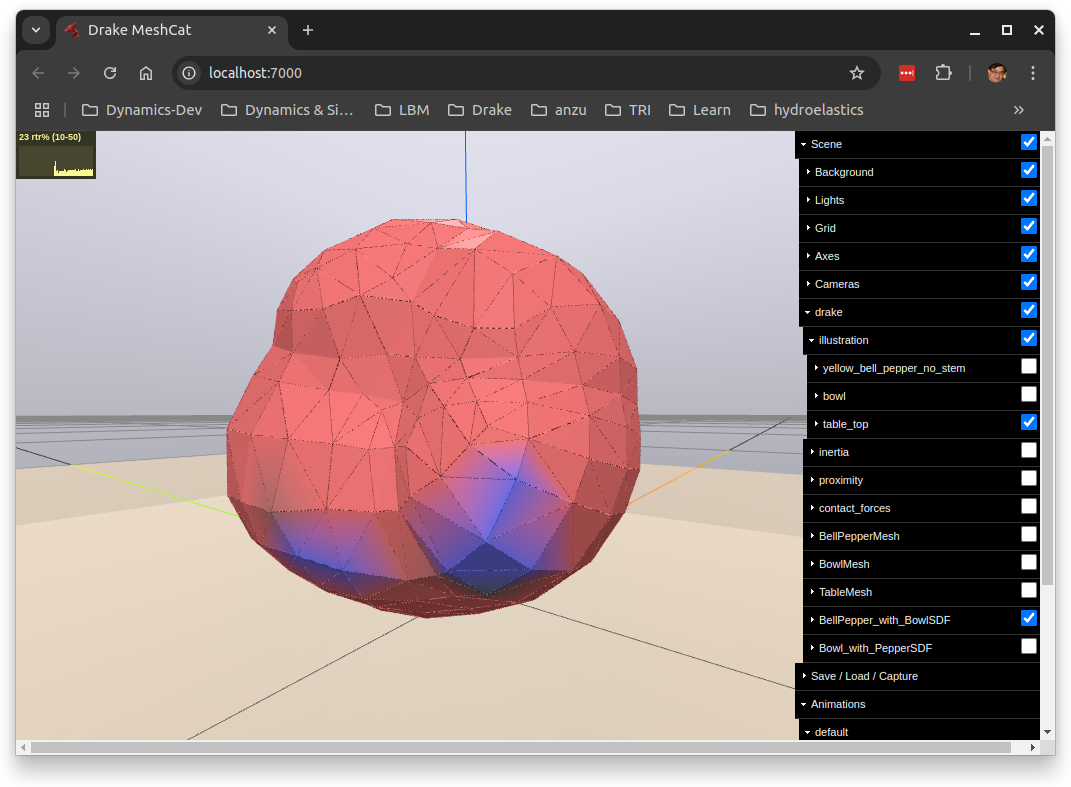

### Need to check accuracy of the clipping algorithm

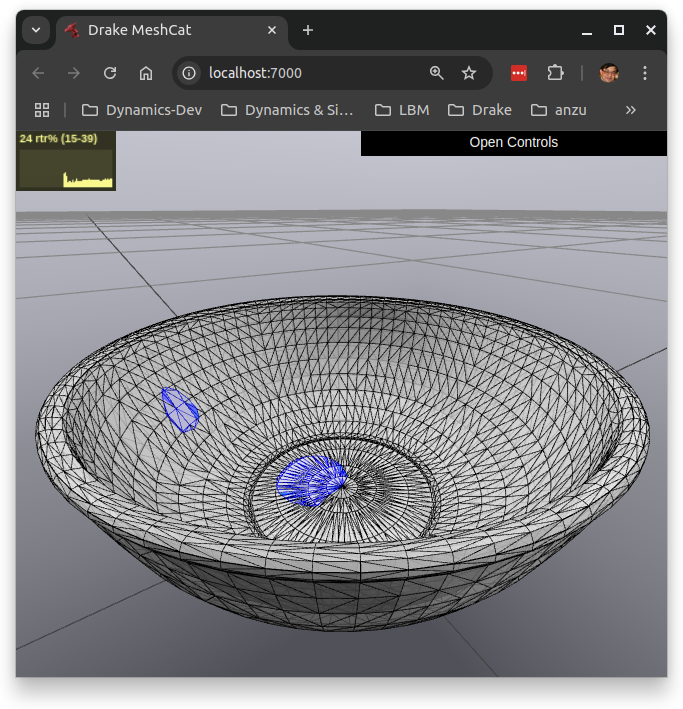
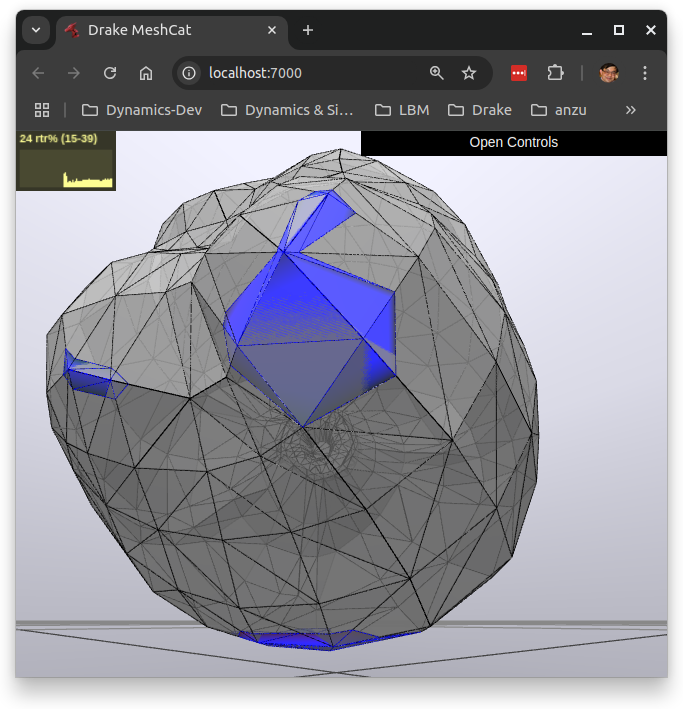


## Download simulation result into a html file for sharing

You can download the simulation result into a self-contained html file, allowing others to playback the simulated results without simulating. The following code prints the URL for downloading. Click on the printed URL to download.

In [ ]:
print(f"{meshcat.web_url()}/download")

## Further reading

* [Hydroelastic Contact User Guide](https://drake.mit.edu/doxygen_cxx/group__hydroelastic__user__guide.html)

* Elandt, R., Drumwright, E., Sherman, M., & Ruina, A. (2019, November). A pressure field model for fast, robust approximation of net contact force and moment between nominally rigid objects. In 2019 IEEE/RSJ International Conference on Intelligent Robots and Systems(IROS) (pp. 8238-8245). IEEE. [link](https://arxiv.org/abs/1904.11433)

* Masterjohn, J., Guoy, D., Shepherd, J., & Castro, A. (2022). Velocity Level Approximation of Pressure Field Contact Patches. IEEE Robotics and Automation Letters 7, no. 4 (2022): 11593-11600. [link](https://arxiv.org/abs/2110.04157v2)

* Elandt, R. (2022, December). Pressure Field Contact. Dissertation. Cornell University. [link](https://ecommons.cornell.edu/handle/1813/112919)